In [528]:
!pip3 install category_encoders

In [529]:
!pip3 install xgboost

In [530]:
!pip3 install scipy

In [531]:
'''import libraries'''
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import category_encoders as ce
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score,accuracy_score,precision_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import classification_report

In [532]:
'''Load CSVs'''
energia_2021 = pd.read_csv('./datasets/energia_202109-202112.csv')
energia_2022 = pd.read_csv('./datasets/energia_202201-202212.csv')
meteo_2021 = pd.read_csv('./datasets/meteo_202109-202112.csv')
meteo_2022 = pd.read_csv('./datasets/meteo_202201-202212.csv')

teste_energia = pd.read_csv('./datasets/energia_202301-202304.csv')
teste_meteo = pd.read_csv('./datasets/meteo_202301-202304.csv')

## Análise dos Dados

#### Full Join dos datasets

In [533]:
energia_21 = energia_2021.copy()
energia_22 = energia_2022.copy() 
energia = pd.merge(energia_21, energia_22, how="outer", on=['Data', 'Hora','Normal (kWh)','Horário Económico (kWh)','Autoconsumo (kWh)','Injeção na rede (kWh)'])

In [534]:
meteo_21 = meteo_2021.copy()
meteo_22 = meteo_2022.copy() 
meteo = pd.merge(meteo_21, meteo_22, how="outer", on=['dt','dt_iso','city_name','temp', 'feels_like', 'temp_min', 'temp_max' , 'pressure', 'sea_level', 'grnd_level', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all', 'weather_description'])

### Join dos datasets Energia e Meteorologia

In [535]:
energia['Data_Hora'] = energia['Data'] + ":" + energia['Hora'].astype(str)
energia['dt'] = energia['Data_Hora'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d:%H').timestamp()).astype('int64')

In [536]:
e_m = pd.merge(meteo, energia, how="inner", on= 'dt')

Teste

In [537]:
teste_energia['Data_Hora'] = teste_energia['Data'] + ":" + teste_energia['Hora'].astype(str)
teste_energia['dt'] = teste_energia['Data_Hora'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d:%H').timestamp()).astype('int64')

In [538]:
teste = pd.merge(teste_meteo, teste_energia, how="inner", on= 'dt')

In [539]:
#for i in teste_meteo.columns:
    #sns.displot(teste_meteo, x=i, kde=True)

In [540]:
#teste_meteo.describe()

## Tratamento dos Dados

### Simplificação dos nomes das features

In [541]:
e_m.rename(columns={"dt": "Timestamp"}, inplace=True)
e_m.rename(columns={"temp": "Temperatura"}, inplace=True)
e_m.rename(columns={"feels_like": "Sensação Térmica"}, inplace=True)
e_m.rename(columns={"temp_min": "Temperatura Mínima"}, inplace=True)
e_m.rename(columns={"temp_max": "Temperatura Máxima"}, inplace=True)
e_m.rename(columns={"pressure": "Pressão Atmosférica"}, inplace=True)
e_m.rename(columns={"humidity": "Humidade"}, inplace=True)
e_m.rename(columns={"wind_speed": "Velocidade Vento"}, inplace=True)
e_m.rename(columns={"rain_1h": "Precipitação Média"}, inplace=True)
e_m.rename(columns={"clouds_all": "Nebulosidade"}, inplace=True)
e_m.rename(columns={"weather_description": "Estado do Tempo"}, inplace=True)
e_m.rename(columns={"Normal (kWh)": "Normal"}, inplace=True)
e_m.rename(columns={"Horário Económico (kWh)": "Horário Económico"}, inplace=True)
e_m.rename(columns={"Autoconsumo (kWh)": "Autoconsumo"}, inplace=True)
e_m.rename(columns={"Injeção na rede (kWh)": "Injeção na Rede"}, inplace=True)

In [542]:
teste.rename(columns={"dt": "Timestamp"}, inplace=True)
teste.rename(columns={"temp": "Temperatura"}, inplace=True)
teste.rename(columns={"feels_like": "Sensação Térmica"}, inplace=True)
teste.rename(columns={"temp_min": "Temperatura Mínima"}, inplace=True)
teste.rename(columns={"temp_max": "Temperatura Máxima"}, inplace=True)
teste.rename(columns={"pressure": "Pressão Atmosférica"}, inplace=True)
teste.rename(columns={"humidity": "Humidade"}, inplace=True)
teste.rename(columns={"wind_speed": "Velocidade Vento"}, inplace=True)
teste.rename(columns={"rain_1h": "Precipitação Média"}, inplace=True)
teste.rename(columns={"clouds_all": "Nebulosidade"}, inplace=True)
teste.rename(columns={"weather_description": "Estado do Tempo"}, inplace=True)
teste.rename(columns={"Normal (kWh)": "Normal"}, inplace=True)
teste.rename(columns={"Horário Económico (kWh)": "Horário Económico"}, inplace=True)
teste.rename(columns={"Autoconsumo (kWh)": "Autoconsumo"}, inplace=True)
teste.rename(columns={"Injeção na rede (kWh)": "Injeção na Rede"}, inplace=True)

### Remoção de features

In [543]:
e_m.drop(['city_name','sea_level','grnd_level'], axis=1, inplace=True)

In [544]:
teste.drop(['city_name','sea_level','grnd_level'], axis=1, inplace=True)

In [545]:
e_m.drop(['Data_Hora'], axis=1, inplace=True)

In [546]:
teste.drop(['Data_Hora'], axis=1, inplace=True)

### Alteração de datas

In [547]:
#def seconds_to_hours(x):
#    return x / 3600

In [548]:
#e_m['Timestamp'] = e_m['Timestamp'].apply(lambda x: seconds_to_hours(x))

In [549]:
#teste['Timestamp'] = teste['Timestamp'].apply(lambda x: seconds_to_hours(x))

In [550]:
e_m.drop(['dt_iso'], axis=1, inplace=True)

In [551]:
teste.drop(['dt_iso'], axis=1, inplace=True)

#### Adicionar colunas a partir da data

Converter o tipo de dados da coluna 'timestamp' para datetime

In [552]:
e_m['Data'] = pd.to_datetime(e_m['Data'], format='%Y-%m-%d', errors='coerce')
assert e_m['Data'].isnull().sum() == 0, 'missing Data'
e_m['Data'].head()

0   2021-09-29
1   2021-09-29
2   2021-09-29
3   2021-09-29
4   2021-09-29
Name: Data, dtype: datetime64[ns]

In [553]:
teste['Data'] = pd.to_datetime(teste['Data'], format='%Y-%m-%d', errors='coerce')
assert teste['Data'].isnull().sum() == 0, 'missing Data'
teste['Data'].head()

0   2023-01-01
1   2023-01-01
2   2023-01-01
3   2023-01-01
4   2023-01-01
Name: Data, dtype: datetime64[ns]

Criação de várias colunas com as partes extraídas da Data

In [554]:
e_m['Ano'] = e_m['Data'].dt.year 
e_m['Mês'] = e_m['Data'].dt.month 
e_m['Dia'] = e_m['Data'].dt.day
e_m.head()

,Timestamp,Temperatura,Sensação Térmica,Temperatura Mínima,Temperatura Máxima,Pressão Atmosférica,Humidade,Velocidade Vento,Precipitação Média,Nebulosidade,Estado do Tempo,Data,Hora,Normal,Horário Económico,Autoconsumo,Injeção na Rede,Ano,Mês,Dia
0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,NaN,87,overcast clouds,2021-09-29,0,0.0,0.0,0.0,NaN,2021,9,29
1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,NaN,91,overcast clouds,2021-09-29,1,0.0,0.0,0.0,NaN,2021,9,29
2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,NaN,93,overcast clouds,2021-09-29,2,0.0,0.0,0.0,NaN,2021,9,29
3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,NaN,95,overcast clouds,2021-09-29,3,0.0,0.0,0.0,NaN,2021,9,29
4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,NaN,93,overcast clouds,2021-09-29,4,0.0,0.0,0.0,NaN,2021,9,29


In [555]:
teste['Ano'] = teste['Data'].dt.year 
teste['Mês'] = teste['Data'].dt.month 
teste['Dia'] = teste['Data'].dt.day
teste.head()

,Timestamp,Temperatura,Sensação Térmica,Temperatura Mínima,Temperatura Máxima,Pressão Atmosférica,Humidade,Velocidade Vento,Precipitação Média,Nebulosidade,Estado do Tempo,Data,Hora,Normal,Horário Económico,Autoconsumo,Ano,Mês,Dia
0,1672531200,12.93,12.76,12.72,13.43,1019,95.0,2.02,3.72,100.0,moderate rain,2023-01-01,0,0.0,0.467,0.0,2023,1,1
1,1672534800,13.49,13.38,13.43,13.90,1018,95.0,2.18,3.26,100.0,moderate rain,2023-01-01,1,0.0,0.577,0.0,2023,1,1
2,1672538400,13.55,13.44,13.48,14.82,1017,95.0,2.88,2.44,100.0,moderate rain,2023-01-01,2,0.0,0.346,0.0,2023,1,1
3,1672542000,13.61,13.51,12.01,14.82,1016,95.0,3.63,1.74,100.0,moderate rain,2023-01-01,3,0.0,0.270,0.0,2023,1,1
4,1672545600,13.59,13.49,12.01,14.82,1015,95.0,4.58,1.13,100.0,moderate rain,2023-01-01,4,0.0,0.252,0.0,2023,1,1


In [556]:
teste.nunique()

Timestamp              2256
Temperatura             918
Sensação Térmica       1007
Temperatura Mínima      384
Temperatura Máxima      538
Pressão Atmosférica      31
Humidade                 71
Velocidade Vento        547
Precipitação Média      120
Nebulosidade             99
Estado do Tempo           8
Data                     94
Hora                     24
Normal                  709
Horário Económico       490
Autoconsumo             485
Ano                       1
Mês                       4
Dia                      31
dtype: int64

In [557]:
e_m.drop(['Data','Ano'], axis=1, inplace=True)

In [558]:
teste.drop(['Data','Ano'], axis=1, inplace=True)

### Converter tipos de dados categóricos para numéricos

#### Injeção na Rede

In [559]:
#e_m['Injeção na Rede'] = pd.factorize(e_m['Injeção na Rede'])[0] + 1

In [560]:
from sklearn.preprocessing import LabelEncoder    

In [561]:
lb_make = LabelEncoder()
e_m['Injeção na Rede'] = lb_make.fit_transform(e_m['Injeção na Rede'])

#### Estado do Tempo

In [562]:
#encoder = ce.BinaryEncoder(cols = ['Estado do Tempo'])
#e_m = encoder.fit_transform(e_m)

In [563]:
#encoder = ce.BinaryEncoder(cols = ['Estado do Tempo'])
#teste = encoder.fit_transform(teste)

In [564]:
lb_make = LabelEncoder()
e_m['Estado do Tempo'] = lb_make.fit_transform(e_m['Estado do Tempo'])

In [565]:
lb_make = LabelEncoder()
teste['Estado do Tempo'] = lb_make.fit_transform(teste['Estado do Tempo'])

### Normalização

In [566]:
from sklearn import preprocessing

In [567]:
e_m.describe()

,Timestamp,Temperatura,Sensação Térmica,Temperatura Mínima,Temperatura Máxima,Pressão Atmosférica,Humidade,Velocidade Vento,Precipitação Média,Nebulosidade,Estado do Tempo,Hora,Normal,Horário Económico,Autoconsumo,Injeção na Rede,Mês,Dia
count,1.101600e+04,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,2284.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000
mean,1.652701e+09,16.182991,15.826868,14.195064,17.288098,1018.396605,76.570715,2.672039,0.896642,54.000908,4.374818,11.500000,0.202278,0.159714,0.117314,3.227487,7.433551,15.803922
std,1.144868e+07,5.756972,6.264860,4.956014,6.164689,6.203379,16.268260,1.476158,1.079381,40.553002,2.403911,6.922501,0.349478,0.271792,0.176762,1.346130,3.578335,8.835905
min,1.632874e+09,0.320000,-2.190000,-0.640000,1.330000,994.000000,19.000000,0.060000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.642787e+09,12.080000,11.507500,10.720000,12.890000,1015.000000,66.000000,1.620000,0.210000,7.000000,3.000000,5.750000,0.000000,0.000000,0.000000,3.000000,4.000000,8.000000
50%,1.652701e+09,15.625000,15.230000,14.230000,16.260000,1018.000000,81.000000,2.400000,0.460000,60.000000,5.000000,11.500000,0.000000,0.000000,0.000000,4.000000,8.000000,16.000000
75%,1.662614e+09,19.270000,19.260000,17.490000,20.340000,1022.000000,91.000000,3.420000,1.092500,98.000000,7.000000,17.250000,0.314000,0.288000,0.227000,4.000000,11.000000,23.000000
max,1.672528e+09,40.850000,41.330000,36.720000,41.450000,1034.000000,100.000000,11.100000,7.450000,100.000000,7.000000,23.000000,3.251000,6.978000,1.192000,4.000000,12.000000,31.000000


In [568]:
from scipy.stats import zscore

In [569]:
numeric_cols = e_m.select_dtypes(include=[np.number]).columns
e_m[numeric_cols].apply(zscore)

,Timestamp,Temperatura,Sensação Térmica,Temperatura Mínima,Temperatura Máxima,Pressão Atmosférica,Humidade,Velocidade Vento,Precipitação Média,Nebulosidade,Estado do Tempo,Hora,Normal,Horário Económico,Autoconsumo,Injeção na Rede,Mês,Dia
0,-1.731894,-0.384419,-0.365048,-0.553911,-0.526912,1.386951,0.272278,-0.482381,NaN,0.813764,0.260080,-1.661325,-0.578826,-0.587660,-0.663713,0.573903,0.437779,1.493529
1,-1.731579,-0.469537,-0.448054,-0.154378,-0.549623,1.548161,0.333750,-0.570452,NaN,0.912405,0.260080,-1.516862,-0.578826,-0.587660,-0.663713,0.573903,0.437779,1.493529
2,-1.731265,-0.565078,-0.535849,-0.297645,-0.625867,1.386951,0.456694,-0.482381,NaN,0.961726,0.260080,-1.372399,-0.578826,-0.587660,-0.663713,0.573903,0.437779,1.493529
3,-1.730950,-0.620665,-0.586930,-0.777891,-0.706977,1.386951,0.518167,-0.556902,NaN,1.011046,0.260080,-1.227936,-0.578826,-0.587660,-0.663713,0.573903,0.437779,1.493529
4,-1.730636,-0.620665,-0.583738,-0.888873,-0.706977,1.386951,0.579639,-0.570452,NaN,0.961726,0.260080,-1.083473,-0.578826,-0.587660,-0.663713,0.573903,0.437779,1.493529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,1.730636,-0.083901,-0.041003,0.277440,-0.254379,-0.063937,0.579639,1.956492,NaN,1.134347,-0.155927,1.083473,4.265757,-0.587660,-0.663713,0.573903,1.276196,1.719888
11012,1.730950,-0.109957,-0.063351,-0.297645,-0.257624,-0.063937,0.641111,1.218056,NaN,1.134347,-0.987942,1.227936,3.218435,-0.587660,-0.663713,0.573903,1.276196,1.719888
11013,1.731265,-0.474749,-0.406551,-0.396519,-0.535023,0.097273,1.009944,0.418647,NaN,1.134347,-0.987942,1.372399,1.587358,-0.587660,-0.663713,0.573903,1.276196,1.719888
11014,1.731579,-0.565078,-0.494346,-0.396519,-0.625867,0.097273,1.071416,-0.800790,NaN,1.134347,-0.155927,1.516862,-0.578826,1.895970,-0.663713,0.573903,1.276196,1.719888


In [570]:
numeric_cols = teste.select_dtypes(include=[np.number]).columns
teste[numeric_cols].apply(zscore)

,Timestamp,Temperatura,Sensação Térmica,Temperatura Mínima,Temperatura Máxima,Pressão Atmosférica,Humidade,Velocidade Vento,Precipitação Média,Nebulosidade,Estado do Tempo,Hora,Normal,Horário Económico,Autoconsumo,Mês,Dia
0,-1.731283,0.430460,NaN,0.616555,0.299111,-0.557575,NaN,-0.573069,NaN,NaN,-0.311535,-1.661325,-0.577441,0.639369,-0.626783,-1.196445,-1.566418
1,-1.729748,0.577049,NaN,0.784556,0.425128,-0.712355,NaN,-0.481007,NaN,NaN,-0.311535,-1.516862,-0.577441,0.932180,-0.626783,-1.196445,-1.566418
2,-1.728212,0.592755,NaN,0.796387,0.671800,-0.867134,NaN,-0.078238,NaN,NaN,-0.311535,-1.372399,-0.577441,0.317277,-0.626783,-1.196445,-1.566418
3,-1.726677,0.608460,NaN,0.448555,0.671800,-1.021913,NaN,0.353300,NaN,NaN,-0.311535,-1.227936,-0.577441,0.114971,-0.626783,-1.196445,-1.566418
4,-1.725141,0.603225,NaN,0.448555,0.671800,-1.176692,NaN,0.899916,NaN,NaN,-0.311535,-1.083473,-0.577441,0.067057,-0.626783,-1.196445,-1.566418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,1.725141,1.843993,NaN,1.667152,2.194729,-1.331471,NaN,0.635239,NaN,NaN,0.899534,1.083473,1.475463,-0.603747,-0.563810,2.111373,-1.230246
2252,1.726677,1.234080,NaN,1.156051,1.269711,-1.176692,NaN,-0.256607,NaN,NaN,0.899534,1.227936,1.393606,-0.603747,-0.626783,2.111373,-1.230246
2253,1.728212,0.796931,NaN,0.943092,0.982821,-1.176692,NaN,-1.044884,NaN,NaN,0.899534,1.372399,0.454397,-0.603747,-0.626783,2.111373,-1.230246
2254,1.729748,0.535166,NaN,0.486414,0.543102,-1.021913,NaN,-1.044884,NaN,NaN,0.899534,1.516862,-0.577441,0.719227,-0.626783,2.111373,-1.230246


### Tratamento de Outliers

In [571]:
from scipy.stats.mstats import winsorize

In [572]:
def get_outliers(lower,upper,field):
    Q1 = e_m[field].quantile(0.25)
    Q3 = e_m[field].quantile(0.75)
    IQR = Q3-Q1

    lower_lim = Q1 - lower * IQR
    upper_lim = Q3 + upper * IQR

    out_low = (e_m[field]<lower_lim)
    out_up = (e_m[field]>upper_lim)

    return [out_low,out_up]

##### Temperatura

In [573]:
#e_m['Temperatura'] = winsorize(e_m['Temperatura'], (0.000182,0.02442))

##### Sensação Térmica

In [574]:
#e_m['Sensação Térmica'] = winsorize(e_m['Sensação Térmica'], (0.0003,0.0242))

##### Temperatura Mínima

In [575]:
outliers_low, outliers_up = get_outliers(1.46,1.4,'Temperatura Mínima')

median = e_m['Temperatura Mínima'].median()

# Substituindo os outliers na coluna 'Temperatura' pelo valor da mediana
e_m.loc[outliers_low | outliers_up, 'Temperatura Mínima'] = median

##### Temperatura Máxima

In [576]:
outliers_low, outliers_up = get_outliers(1.55,1.31,'Temperatura Máxima')

In [577]:
e_m = e_m[~(outliers_low|outliers_up)]

##### Pressão Atmosférica

In [578]:
#e_m['Pressão Atmosférica'] = winsorize(e_m['Pressão Atmosférica'], (0.0258,0.0025))

##### Humidade

In [579]:
#e_m['Humidade'] = winsorize(e_m['Humidade'], (0.0058,0.0))

##### Velocidade Vento

In [580]:
outliers_low, outliers_up = get_outliers(1.5,1.15,'Velocidade Vento')

median = e_m['Velocidade Vento'].median()

# Substituindo os outliers na coluna 'Temperatura' pelo valor da mediana
e_m.loc[outliers_low | outliers_up, 'Velocidade Vento'] = median

##### Precipitação Média

##### Normal

In [581]:
#e_m['Normal'] = winsorize(e_m['Normal'], (0.0,0.0683))

##### Horário Económico

In [582]:
outliers_low, outliers_up = get_outliers(1.5,1.3,'Horário Económico')

median = e_m['Horário Económico'].median()

# Substituindo os outliers na coluna 'Temperatura' pelo valor da mediana
e_m.loc[outliers_low | outliers_up, 'Horário Económico'] = median

##### Autoconsumo

In [583]:
outliers_low, outliers_up = get_outliers(1.5,1.23,'Autoconsumo')

In [584]:
e_m = e_m[~(outliers_low|outliers_up)]

### Tratamento de Missing Values

In [585]:
e_m.isna().sum()

Timestamp                 0
Temperatura               0
Sensação Térmica          0
Temperatura Mínima        0
Temperatura Máxima        0
Pressão Atmosférica       0
Humidade                  0
Velocidade Vento          0
Precipitação Média     7807
Nebulosidade              0
Estado do Tempo           0
Hora                      0
Normal                    0
Horário Económico         0
Autoconsumo               0
Injeção na Rede           0
Mês                       0
Dia                       0
dtype: int64

In [586]:
teste.isna().sum()

Timestamp                 0
Temperatura               0
Sensação Térmica        504
Temperatura Mínima        0
Temperatura Máxima        0
Pressão Atmosférica       0
Humidade                504
Velocidade Vento          0
Precipitação Média     2050
Nebulosidade            504
Estado do Tempo           0
Hora                      0
Normal                    0
Horário Económico         0
Autoconsumo               0
Mês                       0
Dia                       0
dtype: int64

##### Temperatura

In [587]:
#teste['Temperatura'].fillna(teste['Temperatura'].median(), inplace=True)

##### Sensação Térmica

In [588]:
#teste['Sensação Térmica'].fillna(teste['Sensação Térmica'].median(), inplace=True)

##### Temperatura Mínima

In [589]:
#teste['Temperatura Mínima'].fillna(teste['Temperatura Mínima'].median(), inplace=True)

##### Temperatura Máxima

In [590]:
#teste['Temperatura Máxima'].fillna(teste['Temperatura Máxima'].median(), inplace=True)

##### Pressão Atmosférica

In [591]:
#teste['Pressão Atmosférica'].fillna(teste['Pressão Atmosférica'].median(), inplace=True)

##### Humidade

In [592]:
teste['Humidade'].fillna(teste['Humidade'].median(), inplace=True)

##### Velocidade Vento

In [593]:
#teste['Velocidade Vento'].fillna(teste['Velocidade Vento'].median(), inplace=True)

##### Precipitação Média

In [594]:
e_m.drop(['Precipitação Média'], axis=1, inplace=True)

In [595]:
teste.drop(['Precipitação Média'], axis=1, inplace=True)

##### Nebulosidade

In [596]:
teste['Nebulosidade'].fillna(teste['Nebulosidade'].median(), inplace=True)

### Exploratory Data Analysis 

<Axes: >

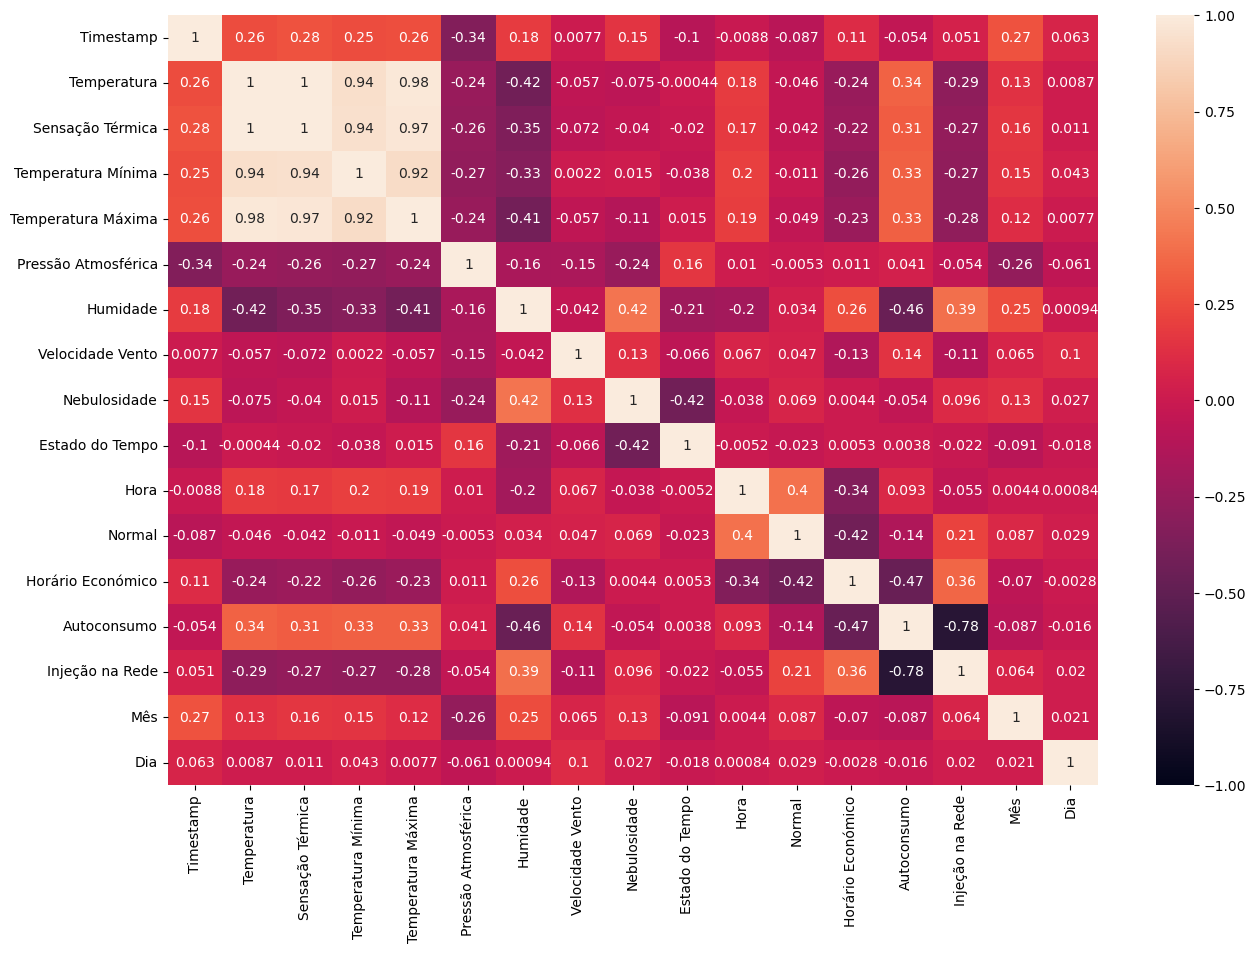

In [597]:
fig = plt.figure(figsize = (15,10))
incidents_corr = e_m.corr(method = 'pearson')
sns.heatmap(e_m.corr(),vmin=-1,annot = True)

Drop das features muito correlacionadas

In [598]:
e_m.drop(['Sensação Térmica','Temperatura','Temperatura Mínima'], axis=1, inplace=True)
teste.drop(['Sensação Térmica','Temperatura','Temperatura Mínima'], axis=1, inplace=True)

## Modelos

In [599]:
X = e_m.drop(['Injeção na Rede'], axis=1)   # input features - tudo exceto o target
y = e_m['Injeção na Rede'].to_frame()       # target feature - Injeção na Rede

In [600]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2011 entries, 10821 to 1168
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Timestamp            2011 non-null   int64  
 1   Temperatura Máxima   2011 non-null   float64
 2   Pressão Atmosférica  2011 non-null   int64  
 3   Humidade             2011 non-null   int64  
 4   Velocidade Vento     2011 non-null   float64
 5   Nebulosidade         2011 non-null   int64  
 6   Estado do Tempo      2011 non-null   int32  
 7   Hora                 2011 non-null   int64  
 8   Normal               2011 non-null   float64
 9   Horário Económico    2011 non-null   float64
 10  Autoconsumo          2011 non-null   float64
 11  Mês                  2011 non-null   int32  
 12  Dia                  2011 non-null   int32  
dtypes: float64(5), int32(3), int64(5)
memory usage: 196.4 KB


### RandomForest

In [601]:
class_weights = {0: 1, 1: 17, 2: 10, 3: 8, 4: 11} 

In [602]:
rfc = RandomForestClassifier(n_estimators=1000,random_state=2023)

In [603]:
n_estimators = [int(x) for x in np.linspace (start = 100, stop = 300, num= 3)] 
max_features = ['sqrt'] 
max_depth = [2,6,10,20,] 
min_samples_split = [2, 5] 
min_samples_leaf = [1, 2] 
bootstrap = [True, False]

# Create the param grid 
param_grid = {'n_estimators': n_estimators, 
              'max_features': max_features, 
              'max_depth': max_depth, 
              'min_samples_split': min_samples_split, 
              'min_samples_leaf': min_samples_leaf, 
              'bootstrap': bootstrap } 

In [604]:
rf_RandomGrid = RandomizedSearchCV(estimator = rfc, param_distributions = param_grid, cv = 5, verbose=1, n_jobs = -1, n_iter = 5, scoring = 'f1_weighted')

In [605]:
rf_RandomGrid.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_estimators=1000,
                                                    random_state=2023),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 6, 10, 20],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200, 300]},
                   scoring='f1_weighted', verbose=1)

In [606]:
rfc = rf_RandomGrid.best_estimator_

In [607]:
pred_rfc = rfc.predict(X_test)

In [608]:
accuracy_score(y_test,pred_rfc)
print(precision_score(y_test, pred_rfc, average='micro'))
print(recall_score(y_test, pred_rfc, average='micro')) 

0.8990551964196917
0.8990551964196917


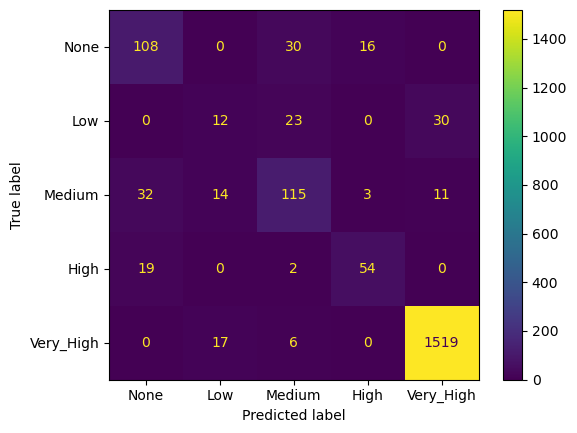

In [609]:
cm = confusion_matrix(y_test,pred_rfc)
cmd = ConfusionMatrixDisplay(cm,display_labels=['None','Low','Medium','High','Very_High'])
cmd.plot()

In [610]:
print(classification_report(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69       154
           1       0.28      0.18      0.22        65
           2       0.65      0.66      0.66       175
           3       0.74      0.72      0.73        75
           4       0.97      0.99      0.98      1542

    accuracy                           0.90      2011
   macro avg       0.67      0.65      0.66      2011
weighted avg       0.89      0.90      0.90      2011



# Guardar Submissão

In [611]:
# Fazer previsão com o RFC
predictions = rfc.predict(teste)

# Adicionar header
submission = pd.DataFrame(predictions, columns = ["Injeção na Rede"]).head(2256)
submission.index.name = 'RowId'
submission.index += 1
submission.rename(columns={'Injeção na Rede': 'Result'}, inplace=True)

# Trocar para valores categóricos
submission['Result'] = submission['Result'].replace({4:'None', 1:'Low', 2:'Medium', 0:'High', 3:'Very_High'})

#Passar para um ficheiro CSV
#submission.to_csv('submission_rf.csv', index=True, header=True)